<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_network_w_Dack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [387]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

CPU times: user 3.59 s, sys: 855 ms, total: 4.44 s
Wall time: 21.9 s


In [388]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [389]:
%%time
import datetime
import glob
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 14.9 ms, sys: 6.3 ms, total: 21.2 ms
Wall time: 20.8 ms


In [390]:
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/137/61,Cluster Workers: 1 Cores: 4 Memory: 27.40 GB


In [391]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

!ls "/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input"

buildings_raw.cpg      buildings_raw_pts.mshp  buildings_raw.shp
buildings_raw.dbf      buildings_raw_pts.prj   buildings_raw.shx
buildings_raw.prj      buildings_raw_pts.shp   GD_wind.csv
buildings_raw_pts.cpg  buildings_raw_pts.shx
buildings_raw_pts.dbf  buildings_raw.qpj


In [0]:
def load_data(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path, file_name), bbox=bbox)
    gdf_buildings['X'] = gdf_buildings.geometry.centroid.x
    gdf_buildings['Y'] = gdf_buildings.geometry.centroid.y

    # print(gdf_buildings.dtypes)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings)/(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    print("Data size:{} GB'".format(data_size))
    # gdf_buildings.IgnProb_bl = 0.02
    # xmin,ymin,xmax,ymax = gdf_buildings.total_bounds

    # Precision of float32 is sufficient for lat and lon
    float_columns = ['SHAPE_Leng','SHAPE_Area',
                    'IgnProb_bl','RandProb']
    gdf_buildings[float_columns] = gdf_buildings[float_columns].astype('float32')
    int_columns = ['TARGET_FID','Combustibl',
                    'AU2013Num','RandProb']
    gdf_buildings[int_columns] = gdf_buildings[int_columns].astype('int32')
    data_size = getsizeof(gdf_buildings)/(1024.0**3)
    print("resized Data size:{} GB'".format(data_size))

    return gdf_buildings


def create_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    # options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
    #            'with_labels': False, 'font_weight': 'bold'}
    # nx.draw_kamada_kawai(graph, **options)
    # plt.show()
    return graph

Shapefile extent : [1744982.88584995 5424124.39445019 1750021.17164993 5430049.56759977]
Asset loaded : 20340
Data size:0.002749629318714142 GB'
resized Data size:0.0022192224860191345 GB'
CPU times: user 12.6 s, sys: 2.5 s, total: 15.1 s
Wall time: 12.6 s


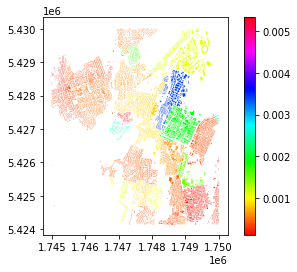

In [393]:
%%time
# load data
# gdf = load_data("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
gdf = load_data("buildings_raw.shp", 1745000, 5424148, 1750000, 5430000) # larger
# gdf = load_data("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole
with ProgressBar():
    gdf.plot(column='IgnProb_bl', cmap='hsv', legend=True)

In [394]:
%%time
@dask.delayed
def create_source_list(gdf):
  fid = gdf.TARGET_FID.values
  source = np.repeat(fid, len(fid))
  DAsource = da.from_array(source, chunks=10000)
  return DAsource

CPU times: user 144 µs, sys: 20 µs, total: 164 µs
Wall time: 159 µs


In [395]:
%%time
@dask.delayed
def create_target_list(gdf):
  fid = gdf.TARGET_FID.values
  target = [fid] * len(fid)
  target = np.hstack(target)
  DAtarget = da.from_array(target, chunks=10000)
  return DAtarget

CPU times: user 119 µs, sys: 16 µs, total: 135 µs
Wall time: 120 µs


In [396]:
%%time
@dask.delayed
def set_edges(Lsource, Ltarget):
  DDF = dd.concat([dd.from_dask_array(DA) for DA in [Lsource, Ltarget]], axis = 1)
  DDF.columns = ['source', 'target']
  DDF['idx'] = 1
  DDF['idx'] = np.cumsum(DDF['idx'])
  DDF= DDF.set_index('idx')
  return DDF

CPU times: user 108 µs, sys: 7 µs, total: 115 µs
Wall time: 99.9 µs


In [397]:
%%time
s = create_source_list(gdf)
t = create_target_list(gdf)
edge_list = set_edges(s,t)

CPU times: user 0 ns, sys: 617 µs, total: 617 µs
Wall time: 571 µs


In [0]:
@dask.delayed
def merge_coordinates(largeDDF, gdf):
  gdf = gdf[['TARGET_FID', 'X', 'Y']]
  ddf = largeDDF.merge(gdf, how='left', left_on='source', right_on='TARGET_FID')
  ddf2 = ddf.merge(gdf, how='left', left_on='target', right_on='TARGET_FID')
  return ddf2

In [0]:
merge = merge_coordinates(edge_list, gdf)

In [0]:
@dask.delayed
def filter(df):
  df['distance'] = ((df.X_x.values - df.X_y.values)**2 + (df.Y_x.values - df.Y_y.values)**2)**0.5
  df = df[(df.distance < 50) & (df.distance != 0)]
  df['azimuth'] = np.degrees(da.arctan2((df.X_x.values - df.X_y.values), (df.Y_x.values - df.Y_y.values)))
  df['bearing'] = (df.azimuth + 360) % 360
  df = df.drop(columns=['TARGET_FID_x', 'TARGET_FID_y'])
  return df

In [0]:
filtered_dask = filter(merge)

In [0]:
%%time
# pbar = ProgressBar()
# pbar.register()

df = filtered_dask.compute()
res = df.compute()

/usr/local/lib/python3.6/dist-packages/distributed/worker.py:2791: UserWarning: Large object of size 4.32 MB detected in task graph: 
  ('set_edges-d4395338-1d8e-4270-8a45-d9b890b1863d', ...  x 11 columns])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [0]:
res.reset_index(inplace=True)

In [0]:
res.to_csv(os.path.join(path_output, 'edge_dask.csv'))